

# Import All Library







In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Read & Cleaning Dataset

In [2]:
dataset = pd.read_csv('nutrition.csv')
dataset.head()

,id,calories,proteins,fat,carbohydrate,name,image
0,1,280.0,9.2,28.4,0.0,Abon,https://img-cdn.medkomtek.com/PbrY9X3ignQ8sVuj...
1,2,513.0,23.7,37.0,21.3,Abon haruwan,https://img-global.cpcdn.com/recipes/cbf330fbd...
2,3,0.0,0.0,0.2,0.0,Agar-agar,https://res.cloudinary.com/dk0z4ums3/image/upl...
3,4,45.0,1.1,0.4,10.8,Akar tonjong segar,https://images.tokopedia.net/img/cache/200-squ...
4,5,37.0,4.4,0.5,3.8,Aletoge segar,https://nilaigizi.com/assets/images/produk/pro...


In [3]:
dataset.info()
dataset.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1346 entries, 0 to 1345
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            1346 non-null   int64  
 1   calories      1346 non-null   float64
 2   proteins      1346 non-null   float64
 3   fat           1346 non-null   float64
 4   carbohydrate  1346 non-null   float64
 5   name          1346 non-null   object 
 6   image         1346 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 73.7+ KB


,0
id,0
calories,0
proteins,0
fat,0
carbohydrate,0
name,0
image,0


### Drop image

In [4]:
dataset.drop(columns=['image'], inplace=True)

In [5]:
print(dataset.head(100))

     id  calories  proteins   fat  carbohydrate                  name
0     1     280.0       9.2  28.4           0.0                  Abon
1     2     513.0      23.7  37.0          21.3          Abon haruwan
2     3       0.0       0.0   0.2           0.0             Agar-agar
3     4      45.0       1.1   0.4          10.8    Akar tonjong segar
4     5      37.0       4.4   0.5           3.8         Aletoge segar
..  ...       ...       ...   ...           ...                   ...
95   96     131.0      20.2   4.3           2.8  Belibis daging segar
96   97      36.0       0.4   0.4           8.8             Belimbing
97   98     145.0       1.2   0.4          34.2  Belitung talas kukus
98   99     417.0      25.9  19.4          32.0          Belut goreng
99  100      70.0      14.6   0.8           1.0           Belut segar

[100 rows x 6 columns]


### Make Coloumn "suitable for diabetes"

In [6]:
carb_threshold = 50  # Batas karbohidrat untuk diabetes
dataset['suitable for diabetes'] = (dataset['carbohydrate'] <= carb_threshold).astype(int)

In [7]:
print(dataset['carbohydrate'].describe())

count    1346.000000
mean       25.390193
std        32.193054
min         0.000000
25%         4.525000
50%        13.300000
75%        37.575000
max       647.000000
Name: carbohydrate, dtype: float64


### Make Coloumn for "glucose"

In [8]:
# Tentukan GI rata-rata
average_gi = 0.55  # Nilai rata-rata untuk estimasi GI

# Hitung estimasi glukosa dalam mg/dL
dataset["glucose"] = dataset["carbohydrate"] * average_gi * 18

In [9]:
print(dataset.head())

   id  calories  proteins   fat  carbohydrate                name  \
0   1     280.0       9.2  28.4           0.0                Abon   
1   2     513.0      23.7  37.0          21.3        Abon haruwan   
2   3       0.0       0.0   0.2           0.0           Agar-agar   
3   4      45.0       1.1   0.4          10.8  Akar tonjong segar   
4   5      37.0       4.4   0.5           3.8       Aletoge segar   

   suitable for diabetes  glucose  
0                      1     0.00  
1                      1   210.87  
2                      1     0.00  
3                      1   106.92  
4                      1    37.62  


In [10]:
print(dataset["glucose"])

0         0.00
1       210.87
2         0.00
3       106.92
4        37.62
         ...  
1341     92.07
1342     82.17
1343     62.37
1344    575.19
1345     39.60
Name: glucose, Length: 1346, dtype: float64


In [11]:
print(dataset['suitable for diabetes'].value_counts())

suitable for diabetes
1    1073
0     273
Name: count, dtype: int64


In [12]:
dataset.to_csv('nutrition1.csv', index=False)

# Preprocessing Data

In [13]:
X = dataset['glucose'].values  # Fitur input (glukosa)
y = dataset['suitable for diabetes'].values  # Label output

In [14]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(-1, 1))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)

In [17]:
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Training Model

In [18]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16)

Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7639 - loss: 0.6604 - val_accuracy: 0.8296 - val_loss: 0.4935
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7948 - loss: 0.5047 - val_accuracy: 0.8296 - val_loss: 0.4321
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7890 - loss: 0.4810 - val_accuracy: 0.8296 - val_loss: 0.4090
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7914 - loss: 0.4431 - val_accuracy: 0.8296 - val_loss: 0.3632
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8028 - loss: 0.3785 - val_accuracy: 0.8296 - val_loss: 0.2793
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8567 - loss: 0.2771 - val_accuracy: 0.9667 - val_loss: 0.1726
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9739 - loss: 0.1779 - val_accuracy: 0.9889 - val_loss: 0.1044
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9816 - loss: 0.1091 - val_accuracy: 0.9889 - val_loss:

In [19]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9835 - loss: 0.0274 
Model Accuracy: 98.89%


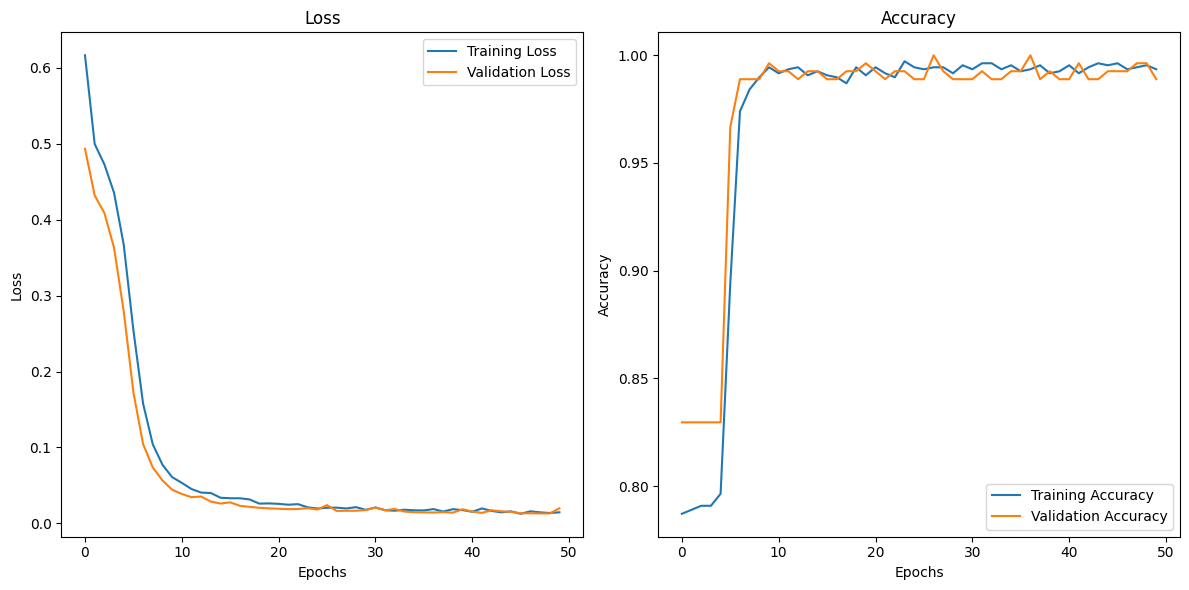

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(12, 6))

#Loss
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
from sklearn.metrics import confusion_matrix, classification_report

# Prediksi pada data validasi
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Laporan klasifikasi
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Confusion Matrix:
[[ 46   0]
 [  3 221]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        46
           1       1.00      0.99      0.99       224

    accuracy                           0.99       270
   macro avg       0.97      0.99      0.98       270
weighted avg       0.99      0.99      0.99       270



# Implementation Model

In [22]:
from tabulate import tabulate

def recommend_food(glucose_input):
    """
    Memberikan rekomendasi makanan berdasarkan kadar glukosa input,
    menampilkan nama makanan, jumlah karbohidrat, kalori, dan estimasi glukosa.

    Args:
        glucose_input (float): Kadar glukosa dalam darah.

    ReReturnsturns:
        str: Rekomendasi makanan dalam bentuk tabel atau pesan kesalahan.
    """
    suitable_foods = dataset[(dataset['glucose'] >= glucose_input - 10) &
                             (dataset['glucose'] <= glucose_input + 10)]

    if suitable_foods.empty:
        return f"Tidak ada makanan dengan estimasi glukosa sekitar {glucose_input} mg/dL."

    # Siapkan data untuk ditampilkan dalam tabel
    table_data = []
    for _, row in suitable_foods.iterrows():
        table_data.append([row['name'], row['carbohydrate'], row['calories'], row['glucose']])

    # Header untuk tabel
    headers = ["Nama Makanan", "Karbohidrat (g)", "Kalori (kcal)", "Estimasi Glukosa (mg/dL)"]

    # Buat tabel
    return tabulate(table_data, headers=headers, tablefmt="grid")

In [23]:
# Contoh input glukosa
glucose_input = 80

# Mencetak rekomendasi makanan
print(recommend_food(glucose_input))

+-----------------------------+-------------------+-----------------+----------------------------+
| Nama Makanan                |   Karbohidrat (g) |   Kalori (kcal) |   Estimasi Glukosa (mg/dL) |
+=============================+===================+=================+============================+
| Alpukat segar               |               7.7 |            85   |                      76.23 |
+-----------------------------+-------------------+-----------------+----------------------------+
| Ampas tahu mentah           |               8.1 |            67   |                      80.19 |
+-----------------------------+-------------------+-----------------+----------------------------+
| Arbei                       |               8.3 |            37   |                      82.17 |
+-----------------------------+-------------------+-----------------+----------------------------+
| Belimbing                   |               8.8 |            36   |                      87.12 |
+---------

# Save Model

In [24]:
model.save("model_glucose.h5")

In [25]:
from google.colab import files
files.download("model_glucose.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>